In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque, namedtuple
import random
import datetime
import itertools
import os
from google.colab import files
import shutil
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


In [ ]:
class QNetworkDueling(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128, update_type='Type-1'):
        super(QNetworkDueling, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, action_size)

        self.update_type = update_type

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        if self.update_type == 'Type-1':
            q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        elif self.update_type == 'Type-2':
            q_values = value + advantage - advantage.max(dim=1, keepdim=True)[0]
        else:
            raise ValueError("Invalid update type. Supported types are 'Type-1' and 'Type-2'.")

        return q_values

## Replay buffer

In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
class DuelingDQNAgent():

    def __init__(self, state_size, action_size, seed,update_type):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetworkDueling(state_size, action_size, seed,update_type).to(device)
        self.qnetwork_target = QNetworkDueling(state_size, action_size, seed,update_type).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

## Dueling algo

In [ ]:

def dqn_dueling(agent, env, n_episodes=1000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995, save_path=None):
    if save_path is not None and os.path.exists(save_path):
        scores = list(np.load(save_path))
        start_episode = len(scores) + 1
        print(f"Resuming training from episode {start_episode}")
    else:
        scores = []
        start_episode = 1

    eps = eps_start

    for i_episode in range(start_episode, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores.append(score)
        eps = max(eps_end, eps_decay*eps)

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))

        if save_path is not None and i_episode % 100 == 0:
            np.save(save_path, np.array(scores))

    return scores


Episode 100	Average Score: -436.42
Episode 200	Average Score: -326.35
Episode 300	Average Score: -270.69
Episode 400	Average Score: -233.02
Episode 500	Average Score: -206.10
Episode 600	Average Score: -186.78
Episode 700	Average Score: -171.94
Episode 800	Average Score: -161.12
Episode 900	Average Score: -151.93
Episode 1000	Average Score: -144.35
Episode 100	Average Score: -430.26
Episode 200	Average Score: -309.69
Episode 300	Average Score: -253.33
Episode 400	Average Score: -213.36
Episode 500	Average Score: -188.60
Episode 600	Average Score: -171.63
Episode 700	Average Score: -158.81
Episode 800	Average Score: -148.68
Episode 900	Average Score: -140.46
Episode 1000	Average Score: -133.69


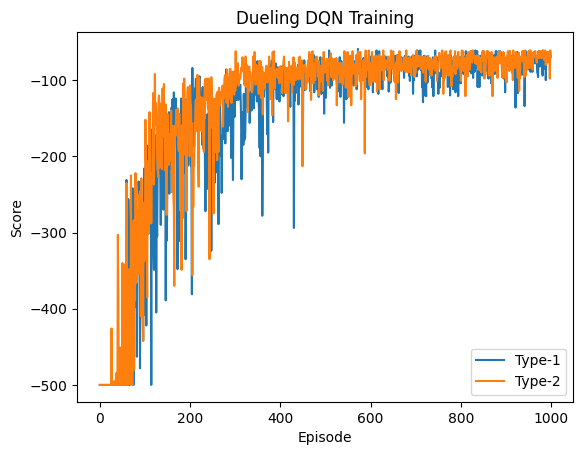

In [ ]:

# Initialize environment and agent
env = gym.make('Acrobot-v1')
env.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the agents
agent_1 = DuelingDQNAgent(state_size=state_size, action_size=action_size, seed=0, update_type='Type-1')
agent_2 = DuelingDQNAgent(state_size=state_size, action_size=action_size, seed=0, update_type='Type-2')

# Train the agents
scores_1 = dqn_dueling(agent_1, env, n_episodes=1000, save_path="scores_1.npy")
scores_2 = dqn_dueling(agent_2, env, n_episodes=1000, save_path="scores_2.npy")

# Plot the scores
plt.plot(scores_1, label='Type-1')
plt.plot(scores_2, label='Type-2')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Dueling DQN Training')
plt.legend()
plt.show()


In [ ]:

# Define hyperparameters to tune
hyperparameters_to_tune = {
    'BUFFER_SIZE': [int(1e4), int(1e5), int(1e6)],
    'BATCH_SIZE': [64, 128],
    'LR': [1e-3, 5e-4, 1e-4],
    'UPDATE_EVERY': [20,25],
}

GAMMA = 0.99

In [ ]:
def plot_mean_and_variance(scores, label, color):
    mean = np.mean(scores, axis=0)
    variance = np.std(scores, axis=0)
    plt.plot(mean, label=label, color=color)
    plt.fill_between(range(len(mean)), mean-variance, mean+variance, color=color, alpha=0.3)



## 5 runs

In [ ]:
# Initialize environment and agent
env = gym.make('Acrobot-v1')
env.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
save_dir = '/content/drive/My Drive/acrobot_results/'

# Make sure the directory exists, otherwise create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for update_type in ['Type-1', 'Type-2']:
    best_hyperparameters= {}
    best_mean_return = -np.inf


    for idx,values in enumerate(itertools.product(*hyperparameters_to_tune.values())):
        # Unpack hyperparameters
        BUFFER_SIZE, BATCH_SIZE, LR, UPDATE_EVERY = values

        # Evaluate performance using 5 random seeds
        returns = []
        agent = DuelingDQNAgent(state_size=state_size, action_size=action_size, seed=0, update_type=update_type)
        scores = dqn_dueling(agent, env, n_episodes=1000, save_path=str(update_type+str(idx)+ str(0) +".npy"))
        returns.append(scores)

        shutil.copy(f'/content/{update_type}{idx}0.npy', save_dir)

        # Check if this hyperparameter combination improves performance
        if np.mean(returns) > best_mean_return:
            best_hyperparameters[update_type] = {
                'BUFFER_SIZE': BUFFER_SIZE,
                'BATCH_SIZE': BATCH_SIZE,
                'GAMMA': GAMMA,
                'LR': LR,
                'UPDATE_EVERY': UPDATE_EVERY
            }
            best_mean_return = np.mean(returns)



In [ ]:
save_dir = '/content/drive/My Drive/acrobot_results/'

# Make sure the directory exists, otherwise create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:

# Plot episodic return versus episodic number for both types
plt.figure(figsize=(10, 6))
for idx, update_type in enumerate(['Type-1', 'Type-2']):
    BUFFER_SIZE, BATCH_SIZE, LR, UPDATE_EVERY  =  best_hyperparameters[update_type]['BUFFER_SIZE'], best_hyperparameters[update_type]['BATCH_SIZE'], best_hyperparameters[update_type]['LR'],best_hyperparameters[update_type]['UPDATE_EVERY']
    returns = []
    for seed in range(5):
        agent = DuelingDQNAgent(state_size=state_size, action_size=action_size, seed=seed, update_type=update_type)
        scores = dqn_dueling(agent, env, n_episodes=1000)
        returns.append(scores)
    np.save(str(update_type+".npy"), np.array(returns))
    shutil.copy(f'/content/{update_type}.npy', save_dir)

    plot_mean_and_variance(returns, label=f'Dueling DQN ({update_type})', color='blue' if update_type == 'Type-1' else 'red')

plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Dueling DQN Training with Best Hyperparameters')
plt.legend()
plt.show()


-131.9398
-138.2376


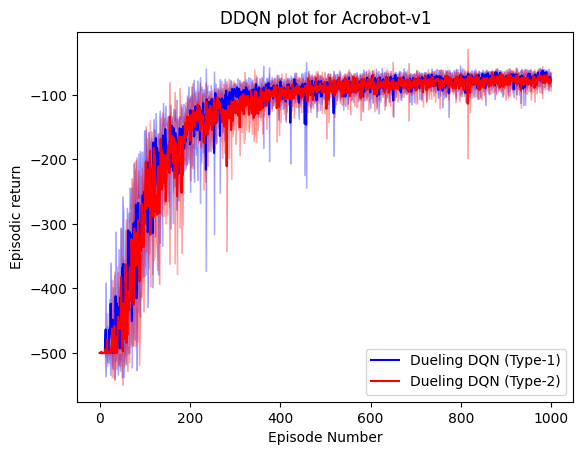

In [ ]:
for idx, update_type in enumerate(['Type-1', 'Type-2']):
  save_path = str(update_type+".npy")
  scores = list(np.load(save_path))
  print(np.mean(scores))
  plot_mean_and_variance(scores, label=f'Dueling DQN ({update_type})', color='blue' if update_type == 'Type-1' else 'red')

plt.xlabel('Episode Number')
plt.ylabel('Episodic return')
plt.title('DDQN plot for Acrobot-v1')
plt.legend()
plt.show()

# MC reinforce

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


Episode 100	Average Score: 40.02
Episode 200	Average Score: 66.98
Episode 300	Average Score: 59.55
Episode 400	Average Score: 69.50
Episode 500	Average Score: 77.71
Episode 600	Average Score: 66.34
Episode 700	Average Score: 60.56
Episode 800	Average Score: 56.09
Episode 900	Average Score: 50.92
Episode 1000	Average Score: 51.74
Episode 100	Average Score: 47.43
Episode 200	Average Score: 92.17
Episode 300	Average Score: 119.40
Episode 400	Average Score: 147.67
Episode 500	Average Score: 174.82
Episode 600	Average Score: 194.18
Episode 700	Average Score: 187.79
Episode 800	Average Score: 174.73
Episode 900	Average Score: 163.39
Episode 1000	Average Score: 149.27
Episode 100	Average Score: 33.46
Episode 200	Average Score: 49.30
Episode 300	Average Score: 52.91
Episode 400	Average Score: 61.88
Episode 500	Average Score: 61.75
Episode 600	Average Score: 69.06
Episode 700	Average Score: 74.16
Episode 800	Average Score: 66.05
Episode 900	Average Score: 59.76
Episode 1000	Average Score: 54.72

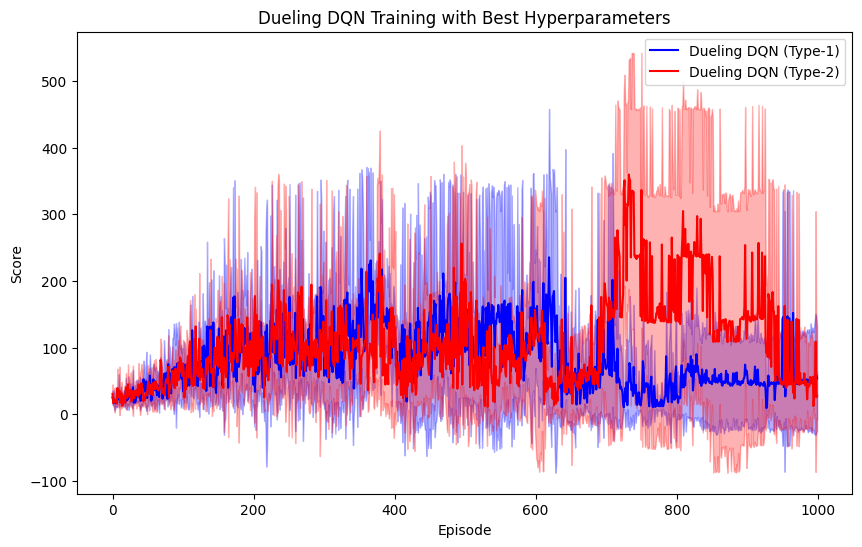

In [ ]:
env = gym.make('CartPole-v1')
env.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Plot episodic return versus episodic number for both types
plt.figure(figsize=(10, 6))
for idx, update_type in enumerate(['Type-1', 'Type-2']):
    BUFFER_SIZE, BATCH_SIZE, LR, UPDATE_EVERY  =  best_hyperparameters[update_type]['BUFFER_SIZE'], best_hyperparameters[update_type]['BATCH_SIZE'], best_hyperparameters[update_type]['LR'],best_hyperparameters[update_type]['UPDATE_EVERY']
    returns = []
    for seed in range(5):
        agent = DuelingDQNAgent(state_size=state_size, action_size=action_size, seed=seed, update_type=update_type)
        scores = dqn_dueling(agent, env, n_episodes=1000)
        returns.append(scores)
    np.save(str("Cartpole_"+update_type+".npy"), np.array(returns))
    shutil.copy(f'/content/Cartpole_{update_type}.npy', save_dir)

    plot_mean_and_variance(returns, label=f'Dueling DQN ({update_type})', color='blue' if update_type == 'Type-1' else 'red')

plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Dueling DQN Training with Best Hyperparameters')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


81.9572
106.333


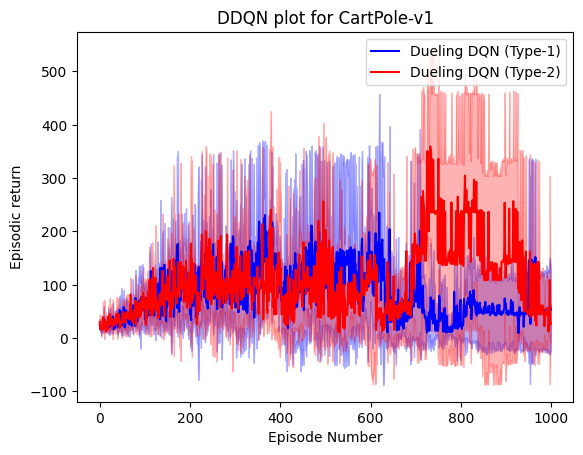

In [ ]:
for idx, update_type in enumerate(['Type-1', 'Type-2']):
  save_path = str("Cartpole_"+update_type+".npy")
  scores = list(np.load(save_path))
  print(np.mean(scores))
  plot_mean_and_variance(scores, label=f'Dueling DQN ({update_type})', color='blue' if update_type == 'Type-1' else 'red')

plt.xlabel('Episode Number')
plt.ylabel('Episodic return')
plt.title('DDQN plot for CartPole-v1')
plt.legend()
plt.show()